<a href="https://colab.research.google.com/github/Embeddedkuba/wakewords/blob/main/tensorflow_01_speech_commands_mfcc_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
!pip install python_speech_features
import python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=d9ecebaa5e7523db901afde43ad7c25e8b9f574567868d66fedad5fe698dfada
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Dataset path and view possible targets
dataset_path = '/content/drive/MyDrive/datasets1sfinal'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)
     

IndentationError: ignored

In [11]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.sort()
print(all_targets)


['PawnToSOLO', 'PawnToSOLOmulti', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up']


In [13]:
# Leave off background noise set
all_targets.remove('PawnToSOLO')
# all_targets.remove('dog')
# all_targets.remove('bird')
# all_targets.remove('bed')
# all_targets.remove('no')
# all_targets.remove('house')
# all_targets.remove('off')
# all_targets.remove('marvin')
# all_targets.remove('happy')
# all_targets.remove('follow')
# all_targets.remove('tree')
# all_targets.remove('learn')
# all_targets.remove('sheila') 

print(all_targets)

['PawnToSOLOmulti', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up']


In [ ]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

3910
3986
1664
1557
4073
2070
3728
3880
3934
3801
3872
3727
3849
3860
3998
3880
3778
3890
3723
6304
Total samples: 73484


In [ ]:
# Settings
target_list = all_targets
feature_sets_file = '/content/drive/MyDrive/datasets1sfinal/all_targets_mfcc_sets.npz'
perc_keep_samples = 0.1 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16


In [ ]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

/content/drive/MyDrive/datasets1s/eight
/content/drive/MyDrive/datasets1s/down
/content/drive/MyDrive/datasets1s/backward
/content/drive/MyDrive/datasets1s/forward
/content/drive/MyDrive/datasets1s/five
/content/drive/MyDrive/datasets1s/cat
/content/drive/MyDrive/datasets1s/four
/content/drive/MyDrive/datasets1s/go
/content/drive/MyDrive/datasets1s/nine
/content/drive/MyDrive/datasets1s/left
/content/drive/MyDrive/datasets1s/stop
/content/drive/MyDrive/datasets1s/three
/content/drive/MyDrive/datasets1s/on
/content/drive/MyDrive/datasets1s/six
/content/drive/MyDrive/datasets1s/seven
/content/drive/MyDrive/datasets1s/two
/content/drive/MyDrive/datasets1s/right
/content/drive/MyDrive/datasets1s/one
/content/drive/MyDrive/datasets1s/up
/content/drive/MyDrive/datasets1s/PawnToMULTI


In [ ]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.]), array([2., 2., 2., ..., 2., 2., 2.]), array([3., 3., 3., ..., 3., 3., 3.]), array([4., 4., 4., ..., 4., 4., 4.]), array([5., 5., 5., ..., 5., 5., 5.]), array([6., 6., 6., ..., 6., 6., 6.]), array([7., 7., 7., ..., 7., 7., 7.]), array([8., 8., 8., ..., 8., 8., 8.]), array([9., 9., 9., ..., 9., 9., 9.]), array([10., 10., 10., ..., 10., 10., 10.]), array([11., 11., 11., ..., 11., 11., 11.]), array([12., 12., 12., ..., 12., 12., 12.]), array([13., 13., 13., ..., 13., 13., 13.]), array([14., 14., 14., ..., 14., 14., 14.]), array([15., 15., 15., ..., 15., 15., 15.]), array([16., 16., 16., ..., 16., 16., 16.]), array([17., 17., 17., ..., 17., 17., 17.]), array([18., 18., 18., ..., 18., 18., 18.]), array([19., 19., 19., ..., 19., 19., 19.])]
3910
3986
1664
1557
4073
2070
3728
3880
3934
3801
3872
3727
3849
3860
3998
3880
3778
3890
3723
6304


In [ ]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [ ]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [ ]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

73484
73484


In [ ]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [ ]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]


In [ ]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [ ]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [ ]:

# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc: #why equal!?
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
        

In [ ]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.0


MFCCs: [[-5.31640327e+01 -5.36788641e+01 -5.42556669e+01 -5.48478062e+01
  -5.54412693e+01 -5.60410242e+01 -5.66579896e+01 -5.73123647e+01
  -5.80126629e+01 -5.86263752e+01 -5.89775606e+01 -5.89321879e+01
  -5.85406883e+01 -5.80350911e+01 -5.75798672e+01 -5.72776277e+01]
 [ 1.33434159e+01  1.32483265e+01  1.31324685e+01  1.30008035e+01
   1.28546594e+01  1.27024278e+01  1.25645646e+01  1.24649923e+01
   1.23741989e+01  1.20720310e+01  1.13331520e+01  1.00496119e+01
   8.36569985e+00  6.63101434e+00  5.06527840e+00  3.72270167e+00]
 [ 1.84676343e-01  7.99413573e-01  1.38647071e+00  1.90596330e+00
   2.35176064e+00  2.72194819e+00  2.99940310e+00  3.16602561e+00
   3.24425004e+00  3.34489754e+00  3.53578079e+00  3.78456690e+00
   3.92401173e+00  3.77420894e+00  3.32485568e+00  2.65439273e+00]
 [-2.55378827e+00 -2.24093343e+00 -1.85946839e+00 -1.43834395e+00
  -9.97563204e-01 -5.56644494e-01 -1.45561219e-01  2.02945316e-01
   4.89040600e-01  7.64403950e-01  1.04200367e+00  1.26757918e+00


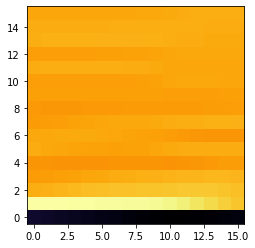

In [ ]:
# TEST: Test shorter MFCC
!pip install playsound
from playsound import playsound

idx = 1

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
#playsound(path) cannot playsound on colab!

In [ ]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length -> why!?
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [ ]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
#print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
#print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
#print('Removed percentage:', prob / len(y_orig_test))

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Dropped: 39115 (16, 11)
Dropped: 39128 (16, 12)
Dropped: 39141 (16, 6)
Dropped: 39156 (16, 15)
Dropped: 39161 (16, 5)
Dropped: 39168 (16, 14)
Dropped: 39172 (16, 5)
Dropped: 39182 (16, 12)
Dropped: 39198 (16, 15)
Dropped: 39203 (16, 13)
Dropped: 39206 (16, 6)
Dropped: 39233 (16, 7)
Dropped: 39235 (16, 4)
Dropped: 39253 (16, 13)
Dropped: 39263 (16, 15)
Dropped: 39267 (16, 14)
Dropped: 39281 (16, 12)
Dropped: 39305 (16, 14)
Dropped: 39330 (16, 11)
Dropped: 39354 (16, 13)
Dropped: 39361 (16, 10)
Dropped: 39366 (16, 15)
Dropped: 39384 (16, 14)
Dropped: 39393 (16, 7)
Dropped: 39398 (16, 13)
Dropped: 39411 (16, 10)
Dropped: 39423 (16, 10)
Dropped: 39428 (16, 15)
Dropped: 39432 (16, 13)
Dropped: 39439 (16, 12)
Dropped: 39442 (16, 14)
Dropped: 39456 (16, 13)
Dropped: 39458 (16, 12)
Dropped: 39468 (16, 14)
Dropped: 39481 (16, 14)
Dropped: 39482 (16, 9)
Dropped: 39490 (16, 13)
Dropped: 39493 (16, 15)
Dropped: 39497 (16, 15)
Dropped

In [ ]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [ ]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [ ]:
len(feature_sets['x_train'])

51784

In [ ]:
print(feature_sets['y_val'])

[29. 11. 23. ...  8. 15. 24.]


In [ ]:
print('xxhx')